In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.manifold import TSNE
import numpy as np
from scipy import linalg
from scipy.stats import gamma
import matplotlib as mpl
from matplotlib.pyplot import figure

In [2]:
def generate_data_1(dim,clusters,samples_per_cluster,spread=3.0, lb=0,ub=200):

  """
  Parameters
  ----------
  dim: int, default=None
       The dimension of features for each sample.

  clusters: int, defult=None
       Number of clusters to generate.

  spread: float or list [lb, up], default=3.0
          If float, variance for each feature in each cluster.
          If list [lb, up], the lower and upper bounds of variance on each feature in each cluster
  
  samples_per_cluster : list, Number of samples in each cluster

  lb,up: int, default lb=0, up=200
        Lower and upper bound of the samples generated  

  Returns
    -------
    X : ndarray of shape (n_samples, n_features)
        The generated samples.
    labels : ndarray of shape (n_samples,)
        The integer labels for cluster membership of each sample.
    centers : ndarray of shape (n_centers, n_features)
        The centers of each cluster.
  """

  centers = np.random.uniform(lb, ub, size=(clusters,dim))
  if isinstance(spread, (float,int)):
        spread  = [spread]*2 
  dim_spread=np.random.uniform(np.sqrt(spread[0]), np.sqrt(spread[1]), size=(clusters,dim))
  X = []
  labels = []
  for i, (n, std) in enumerate(zip(samples_per_cluster, dim_spread)):
        X.append(np.random.normal(loc=centers[i], scale=std, size=(n, dim)))
        labels += [i] * n


  X = np.concatenate(X)
  labels = np.array(labels)
  total_n_samples = np.sum(samples_per_cluster)
  indices = np.arange(total_n_samples)
  np.random.shuffle(indices)
  X = X[indices]
  labels = labels[indices]
  return X, labels, centers


def generate_data_2(samples, dim, clusters, ratio_per_cluster, spread=3.0, lower_bound=0, upper_bound=200):

  """
  Parameters
  ----------
  samples: int default=None
      Number of data points generated.

  dim: int, default=None
       The dimension of features for each sample.

  clusters: int, defult=None
       Number of clusters to generate.

  spread: float or list [lower_bound, upper_bound], default=3.0
          If float, variance for each feature in each cluster.
          If list [lower_bound, upper_bound], the lower and upper bounds of variance on each feature in each cluster
  
  ratio_per_cluster : ndarray of shape (clusters) 
      ratio of samples in each cluster

  lower_bound, upper_bound: int, default lower_bound=0, upper_bound=200
        Lower and upper bound of the samples generated  

  Returns
    -------
    X : ndarray of shape (n_samples, n_features)
        The generated samples.
    labels : ndarray of shape (n_samples,)
        The integer labels for cluster membership of each sample.
    centers : ndarray of shape (n_centers, n_features)
        The centers of each cluster.
  """

  samples_per_cluster = np.int64(samples * ratio_per_cluster)
  print(samples_per_cluster)

  centers = np.random.uniform(lower_bound, upper_bound, size=(clusters,dim))
  if isinstance(spread, (float,int)):
        spread  = [spread]*2 
  dim_spread=np.random.uniform(np.sqrt(spread[0]), np.sqrt(spread[1]), size=(clusters,dim))
  X = []
  labels = []
  for i, (n, std) in enumerate(zip(samples_per_cluster, dim_spread)):
        X.append(np.random.normal(loc=centers[i], scale=std, size=(n, dim)))
        labels += [i] * n


  X = np.concatenate(X)
  labels = np.array(labels)

  indices = np.arange(samples)
  np.random.shuffle(indices)
  X = X[indices]
  labels = labels[indices]
  return X, labels, centers

def dimension_reduction_LDA(X_train,y_train,X,n_components=3):
  """
  Parameters
  ---------
  X_train: training data with known cluster labels
  y_train: labels of training data
  X: data with unkown cluster labels
  n_components: number of components to retain, need to be smaller than the number of classes

  Returns
  ---------
  X: reduced data with dimension n_components 
  """
  lda=LinearDiscriminantAnalysis(n_components=n_components)
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X = sc.transform(X)
  X_train = lda.fit_transform(X_train, y_train)
  X = lda.transform(X)
  return X

def dimension_reduction_PCA(X,n_components=10):
  """
  Parameters
  ---------
  X: data with unknown cluster labels
  n_components: number of components to retain

  Returns
  ---------
  X: reduced data with n_components
  """
  pca = PCA(n_components=n_components)
  X=pca.fit_transform(X)
  return X

def dimension_reduction_TSNE(X, n_components=2):
  """
  Parameters
  ---------
  X: data with unknown cluster labels
  n_components: number of components to retain
  Returns
  ---------
  X: reduced data with n_components
  """
  tSNE = TSNE(n_components=n_components, init='random')
  X=tSNE.fit_transform(X)
  return X

def select_n_dim_data(n,X,labels):
  X_test=[]
  y_test=[]
  for j in range(len(labels)):
    if labels[j] in n:
      X_test.append(X[j])
      y_test.append(labels[j])

  X_res=np.asarray(X_test)
  label_res=np.asarray(y_test)
  return X_res, label_res


def fit_K_means(X,n_clusters):
  kmeans = KMeans(n_clusters=n_clusters).fit(X)
  centers=kmeans.cluster_centers_
  labels=kmeans.labels_
  return centers, labels


def prior_estimation(est,n_observations,data_dim):
  a=est/np.log10(n_observations)
  alpha=2
  beta=alpha*a
  beta=np.floor(beta)
  if est==0:
    alpha=1
    beta=1
  v=data_dim+1
  W0=np.identity(data_dim)
  return alpha, beta,v , W0

def calculate_alpha(alpha,dp_n_components):
    clf_dp = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp.fit(X_train)
    y_pred_dp = clf_dp.predict(X_test)
    dp_arscore = adjusted_rand_score(y_test, y_pred_dp)
    
    pool = mp.Pool(mp.cpu_count())
    results = pool.map(calculate_alpha, [i for i in np.linspace(0.1,2,100)])
    return results

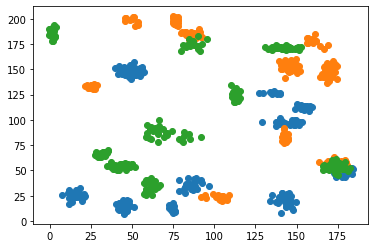

In [ ]:
#Data generating test
X,labels,centers=generate_data_1(dim=100,clusters=10,spread=[1,30],samples_per_cluster=[30,20,10,50,35,20,15,60,25,40])
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.8, random_state=0)

plt.scatter(X[:,0],X[:,1])
plt.scatter(X[:,50],X[:,30])
plt.scatter(X[:,97],X[:,99])
# print(X)
# print(labels)
# print(centers)
X_reduced_LDA=dimension_reduction_LDA(X_train,y_train,X_test,4) #could change up to 10
X_reduced_PCA=dimension_reduction_PCA(X_test,10)


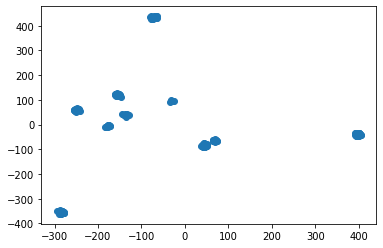

In [ ]:
plt.scatter(X_reduced_PCA[:,1],X_reduced_PCA[:,2])

###Dimension Reduction Techniques

Researches have shown that PCA is the most common approach for reducing dimension for clustering. LDA performs better that PCA, since it finds a new feature space to project the data in order to maximize classes separability. However, it requires a training set that are correctly labeled. 

In [ ]:
def dimension_reduction_LDA(X_train,y_train,X,n_components=3):
  """
  Parameters
  ---------
  X_train: training data with known cluster labels
  y_train: labels of training data
  X: data with unkown cluster labels
  n_components: number of components to retain, need to be smaller than the number of classes

  Returns
  ---------
  X: reduced data with dimension n_components 
  """
  lda=LinearDiscriminantAnalysis(n_components=n_components)
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X = sc.transform(X)
  X_train = lda.fit_transform(X_train, y_train)
  X = lda.transform(X)
  return X_train, X

TOTAL_POINTS = 10000
X, labels, centers = generate_data_2(samples=TOTAL_POINTS, dim=100, clusters=10, spread=[1,30],
                                   ratio_per_cluster=np.array([0.16,0.15,0.05,0.1,0.2,0.05,0.05,0.12,0.08,0.04]))
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
X_train_LDA, X_test_LDA = dimension_reduction_LDA(X_train,y_train,X_test, 4) #could change up to 10

#%% DPGMM comparison 
clf_dp = BGM(n_components=10, weight_concentration_prior_type='dirichlet_process')
clf_dp.fit(X_train)
y_pred_dp = clf_dp.predict(X_test)

# dp_mean = clf.means_,
# dp_cov = clf.covariances_

# plt.figure(1, figsize=(8,8))
# plt.clf()
# plt.scatter(X_train[:,2],X_train[:,3])
# plt.show()

#%% LDA + DPGMM
clf_comb = BGM(n_components=4, weight_concentration_prior_type='dirichlet_process')
clf_comb.fit(X_train_LDA)
y_pred_comb = clf_comb.predict(X_test_LDA)

# comb_mean = clf_comb.means_,
# comb_cov = clf_comb.covariances_

# plt.figure(2, figsize=(8,8))
# plt.clf()
# plt.scatter(X_test_LDA[:,2],X_test_LDA[:,3])
# plt.show()

# ----Need some way to determing k.
#%% K-means 
clf_kmeans = KMeans(n_clusters=10)
clf_kmeans.fit(X_train)
kmeans_mean = clf_kmeans.cluster_centers_
y_pred_kmeans = clf_kmeans.predict(X_test)

#%% use S-score
dp_rscore = rand_score(y_test, y_pred_dp)
comb_rscore = rand_score(y_test, y_pred_comb)
km_rscore = rand_score(y_test, y_pred_kmeans)

dp_sscore = silhouette_score(X_test, y_pred_dp)
comb_sscore = silhouette_score(X_test, y_pred_comb)
km_sscore = silhouette_score(X_test, y_pred_kmeans)

dp_arscore = adjusted_rand_score(y_test, y_pred_dp) # better than rand index as a metrics?
comb_arscore = adjusted_rand_score(y_test, y_pred_comb)
km_arscore = adjusted_rand_score(y_test, y_pred_kmeans)

print(dp_rscore)
print(comb_rscore)
print(km_rscore)

print(dp_sscore)
print(comb_sscore)
print(km_sscore)

print(dp_arscore)
print(comb_arscore)
print(km_arscore)


[1600 1500  500 1000 2000  500  500 1200  800  400]
1.0
0.7927613806903452
1.0
0.9326545841438201
0.526709296737953
0.9326545841438201
1.0
0.4481311866776221
1.0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


###### tSNE ######
0.6042051025512757
0.1301637
0.23365552200974823
{1, 3, 5, 6}
4


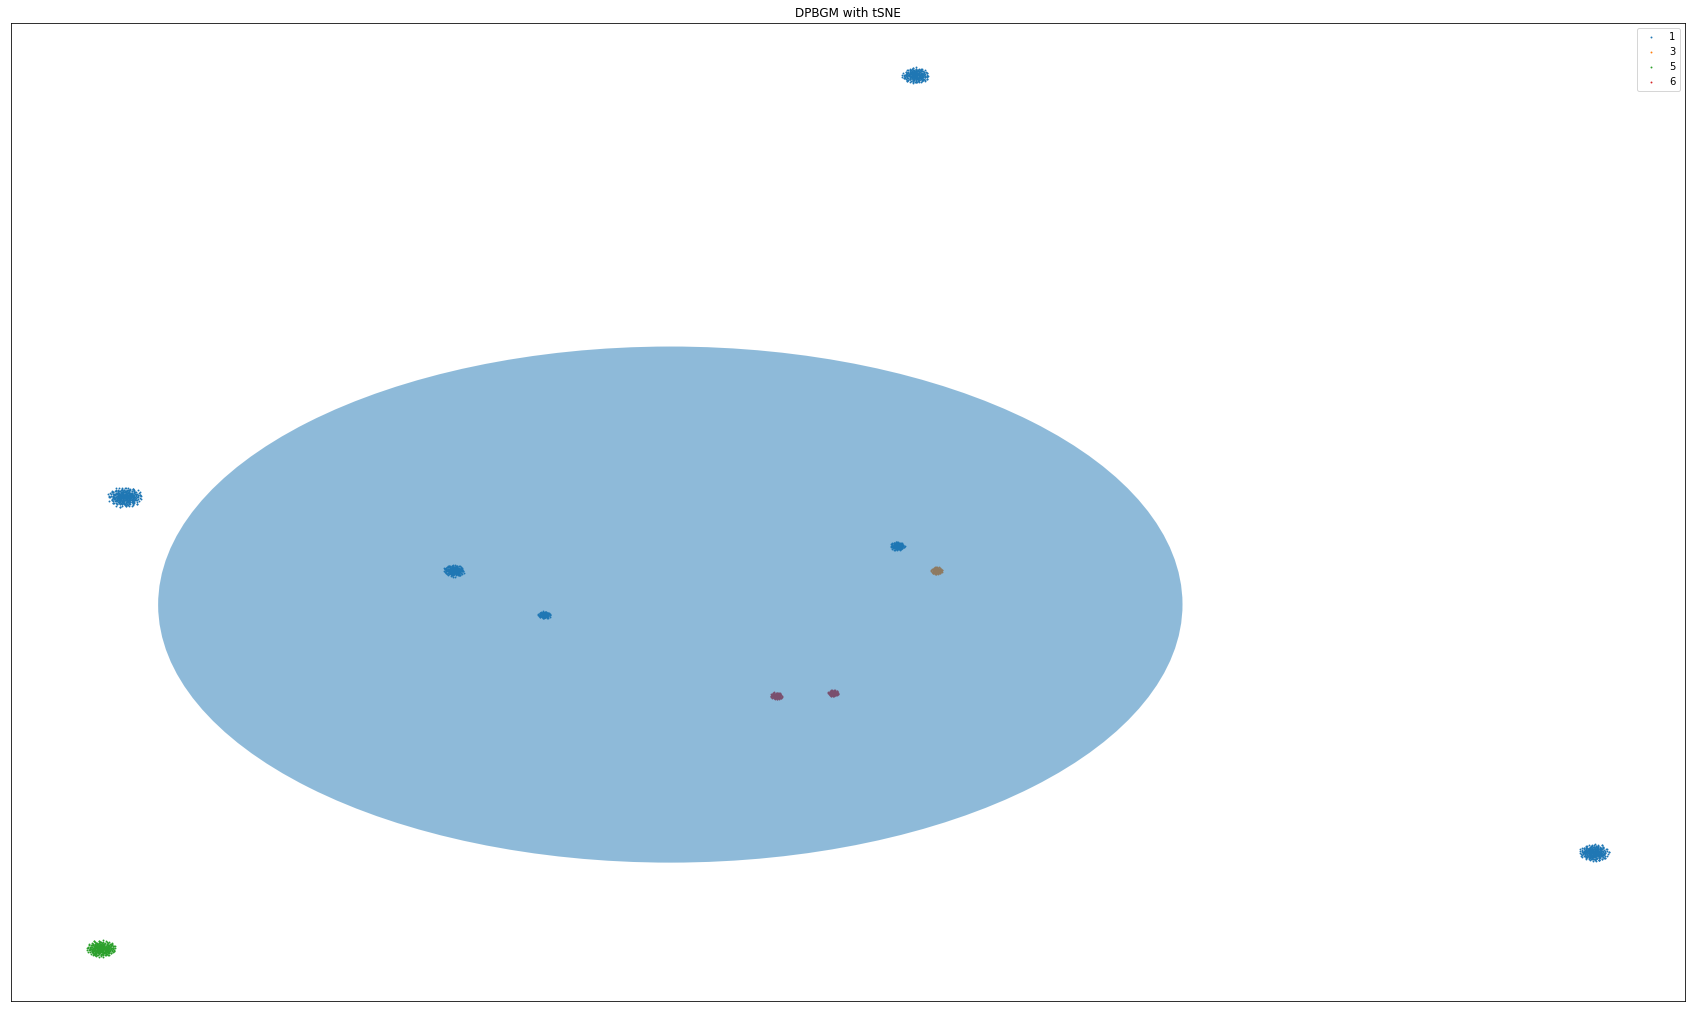

In [ ]:

#Modified from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html 
def plot_results(X, Y_, means, covariances, title):
  _, ax = plt.subplots()
    
  for i, (mean, covar) in enumerate(zip(means, covariances)):
    v, w = linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])

    if not np.any(Y_ == i):
      continue
        
    ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, label = i)

  # Plot an ellipse to show the Gaussian component
  angle = np.arctan(u[1] / u[0])
  angle = 180.0 * angle / np.pi  # convert to degrees
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, label = i)
  # ell.set_clip_box(plt.bbox)
  ell.set_alpha(0.5)
  ax.add_artist(ell)

  plt.xticks(())
  plt.yticks(())
  plt.legend()
  plt.title(title)
  plt.rcParams["figure.figsize"] = (30, 18)
  plt.show()

  #%% try plotting
 

X_train_tSNE = dimension_reduction_TSNE(X_train, 2) #could change up to 10
X_test_tSNE  = dimension_reduction_TSNE(X_test, 2) #could change up to 10

clf_tSNE = BGM(n_components = 20, covariance_type="full", weight_concentration_prior_type='dirichlet_process')
clf_tSNE.fit(X_train_tSNE)
y_pred_tSNE = clf_tSNE.predict(X_test_tSNE)

tSNE_rscore = rand_score(y_test, y_pred_tSNE)
tSNE_sscore = silhouette_score(X_test_tSNE, y_pred_tSNE)
tSNE_arscore = adjusted_rand_score(y_test, y_pred_tSNE)

print('###### tSNE ######')
print(tSNE_rscore)
print(tSNE_sscore)
print(tSNE_arscore)

class_tSNE = set(y_pred_tSNE)
print(class_tSNE)
print(len(class_tSNE))

# if we really need plots ... 
plot_results(
  X_test_tSNE,
  y_pred_tSNE,
  clf_tSNE.means_,
  clf_tSNE.covariances_,
  title="DPBGM with tSNE",
)

Small negative silhouette score in DP means wrong cluster match and overlapping match --> Bad performance. LDA + DP much better. K-means with 1.0 rand index means almost perfect match for X_test. However, to calculate rand index we need 
prior knowledge regardinng true cluster labels --- not feasible for real-world data. LDA could be done only if clients provide some pre-labeled data. Also poked on predicted cluster means for DP: values are not very close to the labels. K-means cluster centers have closer center, however. Worth investigation. From GitHub. 

Things changed when #samples increases. Now DP seems to perform pretty well.

Reduced data is not separated in some dimensions for PCA

In [ ]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.manifold import TSNE
###TESTS on Large Scale Data with no training labels  100000 by 100 dimension
X, labels, centers = generate_data_2(samples=100000, dim=100, clusters=9, spread=20,
                                   ratio_per_cluster=np.array([0.1,0.15,0.05,0.25,0.1,0.05,0.2,0.05,0.05]),lower_bound=0, upper_bound=100)

Reduced_X_PCA=dimension_reduction_PCA(X,n_components=10)
Reduced_X_tSNE=dimension_reduction_PCA(X,n_components=10)
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(Reduced_X_PCA, labels, test_size=0.99, random_state=0)
X_train_tSNE, X_test_tSNE, y_train_tSNE, y_test_tSNE = train_test_split(Reduced_X_PCA, labels, test_size=0.01, random_state=0)
a,b,v,W=prior_estimation(20,1000,10)
clf_dp = BGM(n_components=10, weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=np.random.gamma(a, scale=(1/b)),degrees_of_freedom_prior=v)
clf_dp.fit(X_train_PCA)
y_pred_dp = clf_dp.predict(X_train_PCA)


a=np.unique(y_pred_dp)
centers,res_k_means=fit_K_means(Reduced_X_PCA,len(a))
k_means_res=np.unique(res_k_means)
count1=[]
for i in k_means_res:
  count_i = np.count_nonzero(res == i)
  count1.append(count_i)
print("number of clusters", len(a))
print("number of elements in every cluster", count1)

a,b,v,W=prior_estimation(20,1000,10)
clf_dp = BGM(n_components=10, weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=np.random.gamma(a, scale=(1/b)),degrees_of_freedom_prior=v)
clf_dp.fit(X_train_tSNE)
y_pred_dp_tSNE = clf_dp.predict(X_train_tSNE)


a=np.unique(y_pred_dp_tSNE)
centers,res=fit_K_means(Reduced_X_tSNE,len(a))
k_means_res=np.unique(res)
count2=[]
for i in k_means_res:
  count_i = np.count_nonzero(res == i)
  count2.append(count_i)
print("number of clusters", a)
print("number of elements in every cluster", count2)



        

[10000 15000  5000 25000 10000  5000 20000  5000  5000]
number of clusters 9
number of elements in every cluster [10000, 20000, 25000, 5000, 5000, 15000, 10000, 5000, 5000]
number of clusters [0 1 2 3 5 6 7 8 9]
number of elements in every cluster [20000, 15000, 25000, 10000, 10000, 5000, 5000, 5000, 5000]


In [5]:
# dp_rscore = rand_score(labels,k_means_res)
# dp_sscore = silhouette_score(Reduced_X_PCA, k_means_res)
# dp_arscore = adjusted_rand_score(labels, k_means_res) # better than rand index as a metrics?
# pred_clusters = set(k_means_res)
# fig,((ax_true,ax_pred),(ax_kmean_true,ax4)) = plt.subplots(2,2,figsize = (20,20))
# #fig.suptitle(f'dimension:{dim},n_clusters:{n_clusters},spread:{spread},lb:{lower_bound},ub:{upper_bound}')
# for i in clusters:
#         ax_true.scatter(X_test_tSNE[y_test == i, 0], X_test_tSNE[y_test == i, 1],  label = i,s=1)
#     #ax_true.set_title(f'Ground truth tSNE clusters \n actual num clusters:{len(clusters)}')

# for i in pred_clusters:
#         ax_pred.scatter(X_test_tSNE[k_means_res == i, 0], X_test_tSNE[k_means_res == i, 1],  label = i,s=1)

## Experimnent

In [6]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.manifold import TSNE

def experiment(dim=4,n_clusters=5,spread=20,lower_bound=0,upper_bound=200,dp_n_components=50,\
               n_clusters_mis=5,kmeans_test_start=None,kmeans_test_end=None):
    #data gen
    TOTAL_POINTS = 10000
    ratio_per_cluster = np.array([1/n_clusters]*n_clusters)
    X, labels, centers = generate_data_2(samples=TOTAL_POINTS, dim=dim, clusters=n_clusters, spread=spread,
                                   ratio_per_cluster=ratio_per_cluster,lower_bound=lower_bound, upper_bound=upper_bound)

    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
    #fit
    clusters = set(labels)
    tSNE = TSNE(n_components=2, init='pca')
    X_test_tSNE=tSNE.fit_transform(X_test)
    
    #plot true test clustering
    fig,((ax_true,ax_pred),(ax_kmean_true,ax4)) = plt.subplots(2,2,figsize = (20,20))
    fig.suptitle(f'dimension:{dim},n_clusters:{n_clusters},spread:{spread},lb:{lower_bound},ub:{upper_bound}')
    for i in clusters:
        ax_true.scatter(X_test_tSNE[y_test == i, 0], X_test_tSNE[y_test == i, 1],  label = i,s=1)
    ax_true.set_title(f'Ground truth tSNE clusters \n actual num clusters:{len(clusters)}')
    #fit dpgmm
    clf_dp = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp.fit(X_train)
    y_pred_dp = clf_dp.predict(X_test)
    


    
    #scores
    dp_rscore = rand_score(y_test, y_pred_dp)
    dp_sscore = silhouette_score(X_test, y_pred_dp)
    dp_arscore = adjusted_rand_score(y_test, y_pred_dp) # better than rand index as a metrics?

    
    pred_clusters = set(y_pred_dp)
    for i in pred_clusters:
        ax_pred.scatter(X_test_tSNE[y_pred_dp == i, 0], X_test_tSNE[y_pred_dp == i, 1],  label = i,s=1)
    ax_pred.set_title(f'DPGMM predicted tSNE clusters, n_components = {dp_n_components}\
    \n predicted num clusters:{len(pred_clusters)}\
    \n adjusted random score: {dp_arscore}')
    
    
    #kmean
    clf_kmeans_true = KMeans(n_clusters=n_clusters)
    clf_kmeans_true.fit(X_train)
    y_pred_kmeans_true = clf_kmeans_true.predict(X_test)
    km_true_arscore = adjusted_rand_score(y_test, y_pred_kmeans_true)
    pred_clusters_kmeans_true = set(y_pred_kmeans_true)
    for i in pred_clusters_kmeans_true:
        ax_kmean_true.scatter(X_test_tSNE[y_pred_kmeans_true == i, 0], X_test_tSNE[y_pred_kmeans_true == i, 1],  label = i,s=1)
    ax_kmean_true.set_title(f'k mean,given true cluster size, predicted tSNE clusters\
    \n adjusted random score: {km_true_arscore}')
    
    #kmean mispecify
#     clf_kmeans_mispecify = KMeans(n_clusters=n_clusters_mis)
#     clf_kmeans_mispecify.fit(X_train)
#     y_pred_kmeans_mispecify = clf_kmeans_mispecify.predict(X_test)
#     km_mispecify_arscore = adjusted_rand_score(y_test, y_pred_kmeans_mispecify)
#     pred_clusters_kmeans_mispecify = set(y_pred_kmeans_mispecify)
#     for i in pred_clusters_kmeans_true:
#         ax_kmean_mispecify.scatter(X_test_tSNE[y_pred_kmeans_mispecify == i, 0], X_test_tSNE[y_pred_kmeans_mispecify == i, 1],  label = i,s=1)
#     ax_kmean_mispecify.set_title(f'k mean, with mispecified cluster size= {n_clusters_mis}, predicted tSNE clusters\
#     \n adjusted random score: {km_mispecify_arscore}')
    
    
    #kmean plot
    test_ks = []
    scores = []
    if not kmeans_test_start:
        kmeans_test_start=max(n_clusters-5,0)
    if not kmeans_test_end:
        kmeans_test_end=n_clusters+5
    for k in range(kmeans_test_start,kmeans_test_end+1):
        clf = KMeans(n_clusters = k)
        clf.fit(X_train)
        y_pred = clf.predict(X_test)
        ar_score = adjusted_rand_score(y_test,y_pred)
        test_ks.append(k)
        scores.append(ar_score)
    
    ax4.plot(test_ks,scores)
    ax4.set_title(f'Model selection for k means: Adjusted Random Score vs. num of clusters')
    ax4.set_xlabel('number of clusters')
    ax4.set_ylabel('Adjusted Random Score')

    ax4.hlines(y=dp_arscore, xmin=kmeans_test_start, xmax=kmeans_test_end+1, linewidth=2, color='r')
    

[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500
 500 500]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


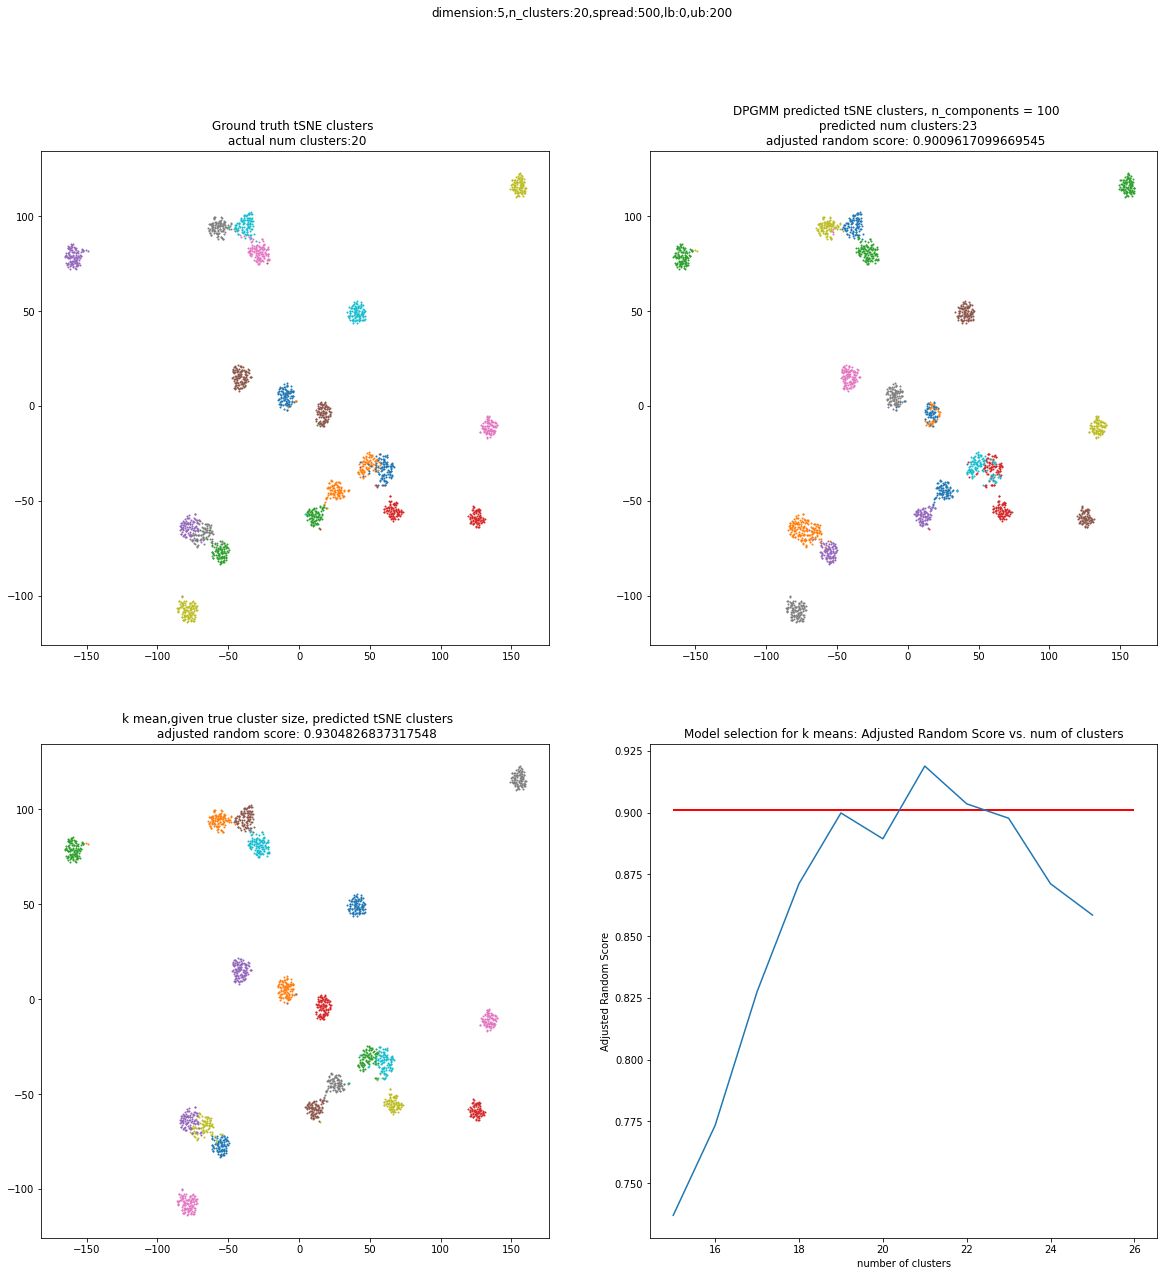

In [ ]:
experiment(dim=5,n_clusters=20,spread=500,lower_bound=0,upper_bound=200,dp_n_components=100,n_clusters_mis=5)

In [ ]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def experiment_dimension_reduction(dim=4,n_clusters=5,spread=20,lower_bound=0,upper_bound=200,dp_n_components=50,\
    pca_dim = 2,lda_dim = 2):
    #data gen
    TOTAL_POINTS = 10000
    ratio_per_cluster = np.array([1/n_clusters]*n_clusters)
    X, labels, centers = generate_data_1(samples=TOTAL_POINTS, dim=dim, clusters=n_clusters, spread=spread,
                                   ratio_per_cluster=ratio_per_cluster,lower_bound=lower_bound, upper_bound=upper_bound)

    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
    #fit
    clusters = set(labels)
    tSNE = TSNE(n_components=2, init='pca')
    X_test_tSNE=tSNE.fit_transform(X_test)
    
    #plot true test clustering
    fig,((ax_true,ax_pred),(ax_pca,ax_lda)) = plt.subplots(2,2,figsize = (20,20))
    fig.suptitle(f'dimension:{dim},n_clusters:{n_clusters},spread:{spread},lb:{lower_bound},ub:{upper_bound}')
    for i in clusters:
        ax_true.scatter(X_test_tSNE[y_test == i, 0], X_test_tSNE[y_test == i, 1],  label = i,s=1)
    ax_true.set_title(f'Ground truth tSNE clusters \n actual num clusters:{len(clusters)}')
    
    #fit dpgmm
    clf_dp = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp.fit(X_train)
    y_pred_dp = clf_dp.predict(X_test)
    
    #scores
    dp_arscore = adjusted_rand_score(y_test, y_pred_dp) # better than rand index as a metrics?

    
    pred_clusters = set(y_pred_dp)
    for i in pred_clusters:
        ax_pred.scatter(X_test_tSNE[y_pred_dp == i, 0], X_test_tSNE[y_pred_dp == i, 1],  label = i,s=1)
    ax_pred.set_title(f'DPGMM predicted tSNE clusters, n_components = {dp_n_components}\
    \n predicted num clusters:{len(pred_clusters)}\
    \n adjusted random score: {dp_arscore}')
    
    #dimension reduction
    
    #pca
    pca = PCA(n_components=pca_dim)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    #fit dpgmm after pca
    clf_dp_pca = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp_pca.fit(X_train_pca)
    y_pred_dp_pca = clf_dp_pca.predict(X_test_pca)
    
    #scores
    dp_arscore_pca = adjusted_rand_score(y_test, y_pred_dp_pca)
    
    pred_clusters_pca = set(y_pred_dp_pca)
    for i in pred_clusters_pca:
        ax_pca.scatter(X_test_tSNE[y_pred_dp_pca == i, 0], X_test_tSNE[y_pred_dp_pca == i, 1],  label = i,s=1)
    ax_pca.set_title(f'DPGMM predicted tSNE clusters,fitted on PCA-processed data, pca dimension = {pca_dim}\
    \n predicted num clusters:{len(pred_clusters_pca)}\
    \n adjusted random score: {dp_arscore_pca}')
    
    
    #lda
    lda = LinearDiscriminantAnalysis(n_components=lda_dim)
    X_train_lda = lda.fit_transform(X_train,y_train)
    X_test_lda = lda.transform(X_test)
    
    #fit dpgmm after lda
    clf_dp_lda = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp_lda.fit(X_train_lda)
    y_pred_dp_lda = clf_dp_lda.predict(X_test_lda)
    
    #scores
    dp_arscore_lda = adjusted_rand_score(y_test, y_pred_dp_lda)
    
    pred_clusters_lda = set(y_pred_dp_lda)
    for i in pred_clusters_lda:
        ax_lda.scatter(X_test_tSNE[y_pred_dp_lda == i, 0], X_test_tSNE[y_pred_dp_lda == i, 1],  label = i,s=1)
    ax_lda.set_title(f'DPGMM predicted tSNE clusters,fitted on LDA-processed data, lda dimension = {lda_dim}\
    \n predicted num clusters:{len(pred_clusters_lda)}\
    \n adjusted random score: {dp_arscore_lda}')
    
    

In [ ]:
def experiment_dimension_reduction_large_n(dim=100,n_clusters=5,spread=20,lower_bound=0,upper_bound=100,dp_n_components=50,\
    pca_dim = 10,lda_dim = 2):
    #data gen
    TOTAL_POINTS = 100000
    ratio_per_cluster = np.array([1/n_clusters]*n_clusters)
    X, labels, centers = generate_data_2(samples=TOTAL_POINTS, dim=dim, clusters=n_clusters, spread=spread,
                                   ratio_per_cluster=np.array([0.1,0.15,0.05,0.25,0.1,0.05,0.2,0.05,0.05]),lower_bound=lower_bound, upper_bound=upper_bound)

    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.99, random_state=0)
    # #fit
    clusters = set(labels)
    tSNE = TSNE(n_components=2, init='pca')
    X_test_tSNE=tSNE.fit_transform(X)
    
    #plot true test clustering
    fig,((ax_true,ax_pred),(ax_pca,ax_lda)) = plt.subplots(2,2,figsize = (20,20))
    fig.suptitle(f'dimension:{dim},n_clusters:{n_clusters},spread:{spread},lb:{lower_bound},ub:{upper_bound}')
    for i in clusters:
        ax_true.scatter(X_test_tSNE[labels == i, 0], X_test_tSNE[labels == i, 1],  label = i,s=1)
    ax_true.set_title(f'Ground truth tSNE clusters \n actual num clusters:{len(clusters)}')

    
    #dimension reduction
    
    #pca
    pca = PCA(n_components=pca_dim)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    #fit dpgmm after pca
    clf_dp_pca = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp_pca.fit(X_train_pca)
    y_pred_dp_pca = clf_dp_pca.predict(X_train_pca)
    
    #k-means for large dataset
    a=np.unique(y_pred_dp_pca)
    count1=[]
    for i in a:
      count_i = np.count_nonzero(res == i)
      count1.append(count_i)
    count1=np.asarray(count1)
    n=len(count1)
    for i in range(len(count1)):
      if count1[i]<np.sum(count1)*0.05:
        n=n-1
    
    centers,res_k_means=fit_K_means(X,n)
    

    #scores
    dp_arscore_pca = adjusted_rand_score(labels, res_k_means)
    
    pred_clusters_pca = set(res_k_means)
    for i in pred_clusters_pca:
        ax_pca.scatter(X_test_tSNE[res_k_means == i, 0], X_test_tSNE[res_k_means == i, 1],  label = i,s=1)
    ax_pca.set_title(f'DPGMM predicted tSNE clusters,fitted on PCA-processed data, pca dimension = {pca_dim}\
    \n predicted num clusters:{len(pred_clusters_pca)}\
    \n adjusted random score: {dp_arscore_pca}')

    

[10000 15000  5000 25000 10000  5000 20000  5000  5000]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


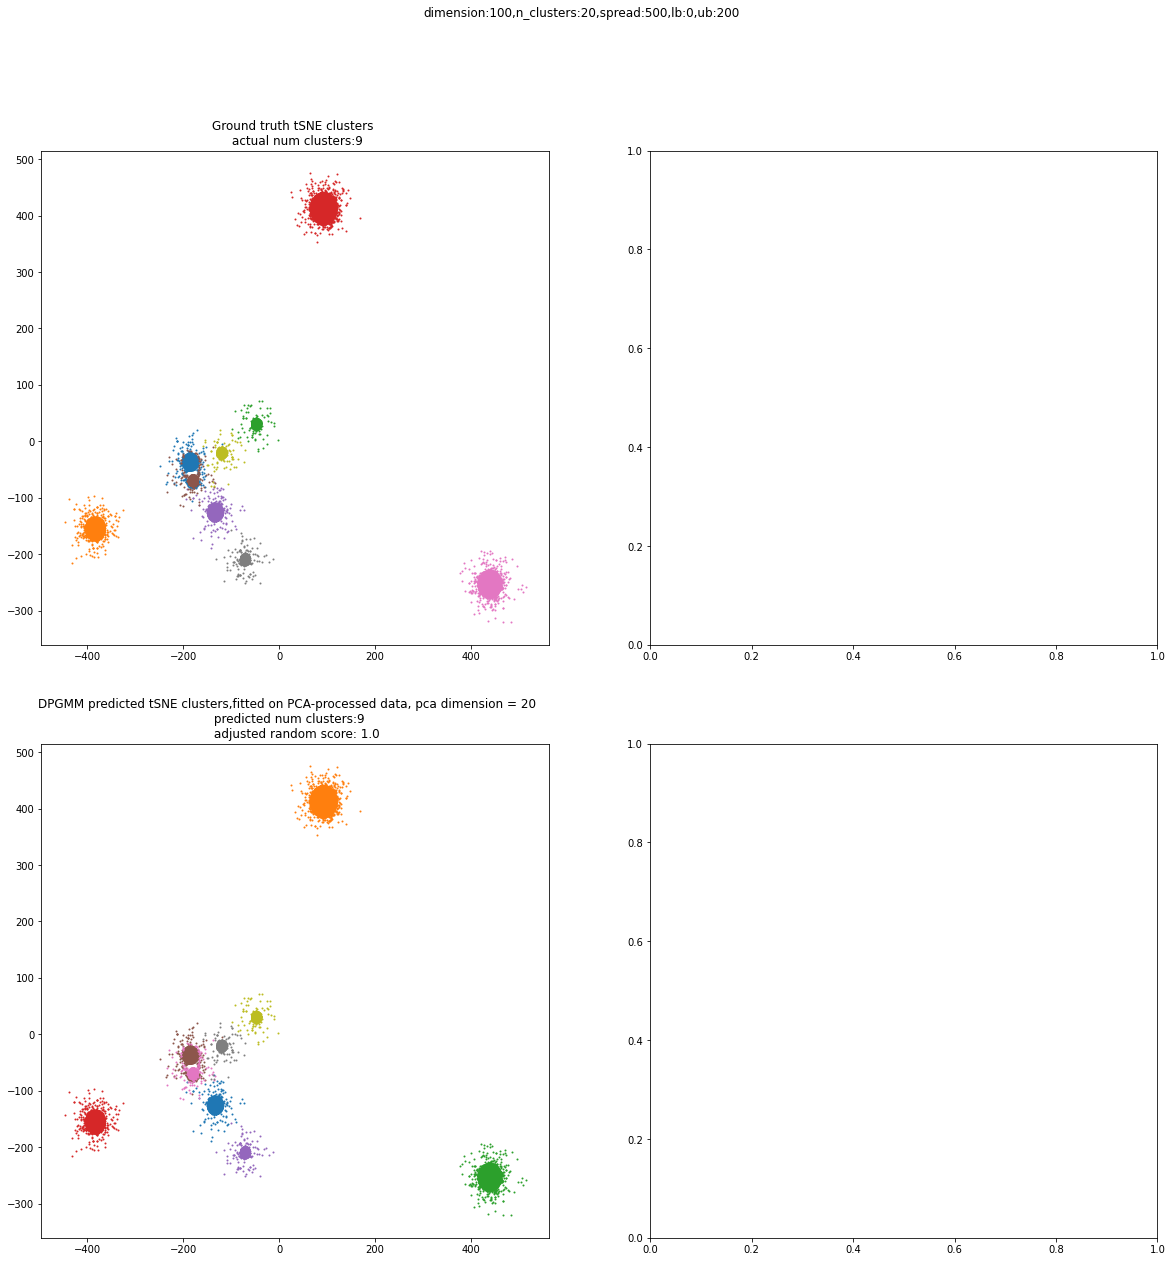

In [ ]:
experiment_dimension_reduction_large_n(dim=100,n_clusters=20,spread=500,lower_bound=0,upper_bound=200,dp_n_components=50,\
    pca_dim = 20,lda_dim = 20)

### AutoEncoders

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score, mean_squared_error
from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import pandas as pd
import seaborn as sn

# from DataGenerator import DataGenerator
# import utils

from tqdm import tqdm

In [2]:
class MLPAE(nn.Module):
  def __init__(self, in_components, out_components):
    super(MLPAE, self).__init__()

    self.in_features = in_components
    self.out_features = out_components

    self.Encoder = nn.Sequential(
      nn.Linear(in_features=self.in_features, out_features=256),
      nn.ReLU(inplace=False),
      nn.Linear(in_features=256, out_features=64),
      nn.ReLU(inplace=False),      
      nn.Linear(in_features=64, out_features=self.out_features),
      
    )

    self.Decoder = nn.Sequential(

      nn.Linear(in_features=self.out_features, out_features=64),
      nn.ReLU(inplace=False),      
      nn.Linear(in_features=64, out_features=256),
      nn.ReLU(inplace=False),      
      nn.Linear(in_features=256, out_features=self.in_features),
    )

  def forward(self, x):
    encoder = self.Encoder(x)
    decoder = self.Decoder(encoder)
    return encoder, decoder

### Utility ...

In [3]:
def train(model, device, train_loader, criterion, optimizer):
  model.train()

  train_loss = 0

  for _, (data, _) in enumerate(train_loader):
    
    data = data.to(device)
    optimizer.zero_grad()
    _, decoded_data = model(data)

    loss = criterion(data, decoded_data)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  avg_loss = train_loss / len(train_loader)
  
  return avg_loss

def get_datasets(model, device, train_loader, test_loader, batch_size):
  X_test = []
  X_train = []
    
  decode_X_train = []

  with torch.no_grad():
    for _, (data, labels) in enumerate(train_loader):
      data = data.to(device)
      labels = labels.to(device)

      transformed_data, decoded_data = model(data)
      transformed_data = np.asarray(transformed_data.detach().cpu().numpy())
      decoded_data = np.asarray(decoded_data.detach().cpu().numpy())

      X_train.append(transformed_data)
      decode_X_train.append(decoded_data)
    

    for _, (data, labels) in enumerate(test_loader):
      data = data.to(device)
      labels = labels.to(device)     

      transformed_data, _ = model(data)
      transformed_data = np.asarray(transformed_data.detach().cpu().numpy())

      X_test.append(transformed_data)

  rep_dim = X_train[0].shape[1]

  out_dim = decode_X_train[0].shape[1]
  X_train = np.reshape(np.asarray(X_train), (len(train_loader) * batch_size, rep_dim))
  X_test = np.reshape(np.asarray(X_test), (len(test_loader) * batch_size, rep_dim))
  decode_X_train = np.reshape(np.asarray(decode_X_train), (len(train_loader) * batch_size, out_dim))

  return X_train, X_test, decode_X_train

In [12]:
#%% Try DNN on Image-like data
### should be generate_data2
# TOTAL_POINTS = 100000
# IMAGE_DIM = 32
# OUTPUT_DIM = 16
# N_CLUSTERS = 10
# RATIOS = np.array([0.16,0.15,0.05,0.1,0.2,0.05,0.05,0.12,0.08,0.04]) # might need random assignments for ratio

# #def generate_data_2(samples, dim, clusters, ratio_per_cluster, spread=3.0, lower_bound=0, upper_bound=200):
# # generate_data_2(samples=TOTAL_POINTS, dim=IMAGE_DIM*IMAGE_DIM, clusters=N_CLUSTERS, spread=20, ratio_per_cluster=RATIOS, lower_bound=0, upper_bound=100)
# X, labels, centers = generate_data_2(samples=TOTAL_POINTS, dim=IMAGE_DIM*IMAGE_DIM, clusters=N_CLUSTERS, spread=20, ratio_per_cluster=RATIOS, lower_bound=0, upper_bound=100)
# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.8, random_state=0)

# train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
# print(X.shape)

[16000 15000  5000 10000 20000  5000  5000 12000  8000  4000]
(100000, 1024)


In [14]:
# #%% DNN Fun
# ### Need StandardScaler?
# EPOCHS = 10
# BATCH_SIZE = 50
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

# train_losses = np.zeros(EPOCHS)
# model = MLPAE(in_components=IMAGE_DIM*IMAGE_DIM, out_components=OUTPUT_DIM).to(device)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in tqdm(range(EPOCHS)):
#   train_loss = train(model, device, train_loader, criterion, optimizer)

#   train_losses[epoch] = train_loss
#   print(f'Training loss for AE is: {train_loss}')

# X_train_dnn, X_test_dnn, decode_X_train_dnn = get_datasets(model, device, train_loader, test_loader, batch_size=BATCH_SIZE)
# print(X_train_dnn.shape)
# print(X_test_dnn.shape)
# print(decode_X_train_dnn.shape)
#%% DNN Fun
### Need StandardScaler?
def get_model_representation(X_train, X_test, y_train, y_test,epochs=10,bs=50,in_dim=1024,out_dim=16):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    EPOCHS = epochs
    BATCH_SIZE = bs
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    train_losses = np.zeros(EPOCHS)
    model = MLPAE(in_components=in_dim, out_components=out_dim).to(device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in tqdm(range(EPOCHS)):
      train_loss = train(model, device, train_loader, criterion, optimizer)

      train_losses[epoch] = train_loss
      print(f'Training loss for AE is: {train_loss}')
    
    X_train_dnn, X_test_dnn, decode_X_train_dnn = get_datasets(model, device, train_loader, test_loader, batch_size=BATCH_SIZE)
    print(X_train_dnn.shape)
    print(X_test_dnn.shape)
    print(decode_X_train_dnn.shape)
    return X_train_dnn,X_test_dnn

cpu


 10%|█         | 1/10 [00:06<00:54,  6.01s/it]

Training loss for AE is: 306.53737863540647


 20%|██        | 2/10 [00:12<00:51,  6.48s/it]

Training loss for AE is: 21.047803649902345


 30%|███       | 3/10 [00:19<00:45,  6.48s/it]

Training loss for AE is: 20.96647234916687


 40%|████      | 4/10 [00:25<00:37,  6.28s/it]

Training loss for AE is: 20.99825174331665


 50%|█████     | 5/10 [00:31<00:30,  6.19s/it]

Training loss for AE is: 21.03595495223999


 60%|██████    | 6/10 [00:37<00:24,  6.19s/it]

Training loss for AE is: 21.055855450630187


 70%|███████   | 7/10 [00:44<00:18,  6.33s/it]

Training loss for AE is: 21.281779856681823


 80%|████████  | 8/10 [00:50<00:12,  6.21s/it]

Training loss for AE is: 21.256226963996887


 90%|█████████ | 9/10 [00:56<00:06,  6.15s/it]

Training loss for AE is: 20.97051842689514


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]

Training loss for AE is: 21.302184085845948


(20000, 16)
(80000, 16)
(20000, 1024)


In [ ]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def experiment_dimension_reduction_autoencoder(dim=4,n_clusters=5,spread=20,lower_bound=0,upper_bound=200,dp_n_components=50,\
    epochs=10,bs=50,rep_dim=16):
    #data gen
    TOTAL_POINTS = 10000
    ratio_per_cluster = np.array([1/n_clusters]*n_clusters)
    X, labels, centers = generate_data_2(samples=TOTAL_POINTS, dim=dim, clusters=n_clusters, spread=spread,
                                   ratio_per_cluster=ratio_per_cluster,lower_bound=lower_bound, upper_bound=upper_bound)

    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
    #fit
    clusters = set(labels)
    tSNE = TSNE(n_components=2, init='pca')
    X_test_tSNE=tSNE.fit_transform(X_test)
    
    #plot true test clustering
    fig,(ax_true,ax_pred,ax_ae) = plt.subplots(1,3,figsize = (30,10))
    fig.suptitle(f'dimension:{dim},n_clusters:{n_clusters},spread:{spread},lb:{lower_bound},ub:{upper_bound}')
    for i in clusters:
        ax_true.scatter(X_test_tSNE[y_test == i, 0], X_test_tSNE[y_test == i, 1],  label = i,s=1)
    ax_true.set_title(f'Ground truth tSNE clusters \n actual num clusters:{len(clusters)}')
    
    #fit dpgmm
    clf_dp = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp.fit(X_train)
    y_pred_dp = clf_dp.predict(X_test)
    
    #scores
    dp_arscore = adjusted_rand_score(y_test, y_pred_dp) # better than rand index as a metrics?

    
    pred_clusters = set(y_pred_dp)
    for i in pred_clusters:
        ax_pred.scatter(X_test_tSNE[y_pred_dp == i, 0], X_test_tSNE[y_pred_dp == i, 1],  label = i,s=1)
    ax_pred.set_title(f'DPGMM predicted tSNE clusters, n_components = {dp_n_components}\
    \n predicted num clusters:{len(pred_clusters)}\
    \n adjusted random score: {dp_arscore}')
    
    #dimension reduction with auto encoder
    #pca 
         
    X_train_ae,X_test_ae = get_model_representation(X_train, X_test, y_train, y_test,epochs=epochs,bs=bs,in_dim=dim,out_dim=rep_dim)
    
    #fit dpgmm after pca
    clf_dp_ae = BGM(n_components=dp_n_components, weight_concentration_prior_type='dirichlet_process')
    clf_dp_ae.fit(X_train_ae)
    y_pred_dp_ae = clf_dp_ae.predict(X_test_ae)
    
    #scores
    dp_arscore_ae = adjusted_rand_score(y_test, y_pred_dp_ae)
    
    pred_clusters_ae = set(y_pred_dp_ae)
    for i in pred_clusters_ae:
        ax_ae.scatter(X_test_tSNE[y_pred_dp_ae == i, 0], X_test_tSNE[y_pred_dp_ae == i, 1],  label = i,s=1)
    ax_ae.set_title(f'DPGMM predicted tSNE clusters,fitted on Autoencoder-processed data, Autoencoder representation dimension = {rep_dim}\
    \n predicted num clusters:{len(pred_clusters_ae)}\
    \n adjusted random score: {dp_arscore_ae}')
    

In [ ]:
experiment_dimension_reduction_autoencoder(dim=100,n_clusters=20,spread=500,\
                                           lower_bound=0,upper_bound=200,dp_n_components=50,\
                                            epochs=10,bs=50,rep_dim=20)

### ICA stuff

In [ ]:
# ICA
ica = FastICA(n_components=OUTPUT_DIM)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

#fit dpgmm after pca
clf_dp_ica = BGM(n_components=50, weight_concentration_prior_type='dirichlet_process')
clf_dp_ica.fit(X_train_ica)
y_pred_dp_ica = clf_dp_ica.predict(X_train_ica)